In [61]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [62]:
(x_train,y_train),(_,_)=tf.keras.datasets.mnist.load_data()

In [63]:
x_train.shape

(60000, 28, 28)

In [64]:
y_train.shape

(60000,)

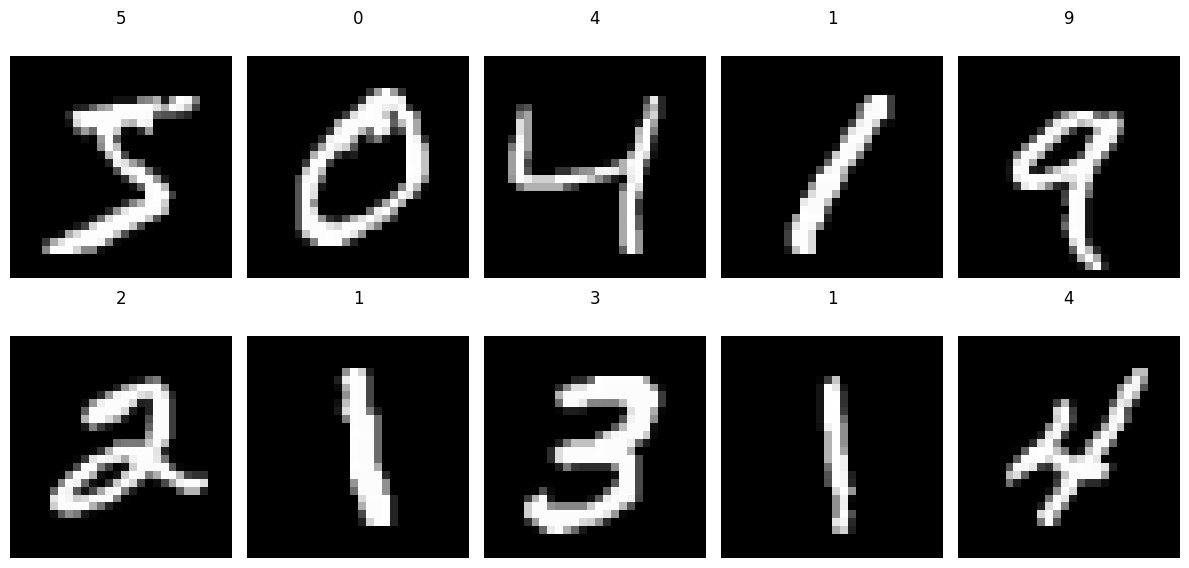

In [65]:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(x_train[n], cmap='gray')
        axs[i,j].set(title=y_train[n])
        axs[i,j].axis('off')
        n=n+1
plt.show() 

In [66]:
data=x_train.copy()
data=data.reshape(x_train.shape[0],28,28,1)

In [67]:
data.shape


(60000, 28, 28, 1)

In [68]:
data=(data-127.5)/127.5

In [69]:
def generator(latent_dim,in_shape=(7,7,1),cat=10):
    in_label=Input(shape=(1,))
    lbs=Embedding(cat,50)(in_label)
    
    n_nodes=in_shape[0]*in_shape[1]
    lbs=Dense(n_nodes)(lbs)
    lbs=Reshape((in_shape[0],in_shape[1],1))(lbs)
    
    in_latent=Input(shape=latent_dim)
    n_nodes=7*7*128
    g=Dense(n_nodes)(in_latent)
    g=ReLU()(g)
    g=Reshape((in_shape[0],in_shape[1],128))(g)
    
    
    concat=Concatenate()([g,lbs])
    
    g=Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding='same')(concat)
    g=ReLU()(g)
    
    g=Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),padding='same')(g)
    g=ReLU()(g)
    
    output=Conv2D(filters=1, kernel_size=(7,7), activation='tanh',padding='same')(g)
    
    model=Model([in_latent,in_label],output)
    return model

In [70]:
gen_model=generator(100)

In [72]:
def discriminator(in_shape=(28,28,1),cats=10):
    
    in_label=Input(shape=(1,))
    lbs=Embedding(cats,50)(in_label)
    
    n_nodes=in_shape[0]*in_shape[1]
    lbs=Dense(n_nodes)(lbs)
    lbs=Reshape((in_shape[0],in_shape[1],1))(lbs)
    
    
    in_image=Input(shape=in_shape)
    
    concat=Concatenate()([in_image,lbs])
    
    
    h=Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),padding='same')(concat)
    h=LeakyReLU(alpha=0.2)(h)
    
    h=Conv2D(filters=128, kernel_size=(3,3), strides=(2,2),padding='same')(h)
    h=LeakyReLU(alpha=0.2)(h)
    h=MaxPool2D(pool_size=(3,3),strides=(2,2))(h)
    
    h=Flatten()(h)
    h=Dropout(0.2)(h)
    
    output=Dense(1,activation='sigmoid')(h)
    
    model=Model([in_image,in_label],output)
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0002, beta_1=0.5),metrics=['accuracy'])
    
    return model

In [73]:
dis_model=discriminator()

In [74]:
def define_gan(generator,discriminator):
    discriminator.trainable=False
    
    gen_latent,gen_label=generator.input
    gen_output=generator.output
    
    gan_output=discriminator([gen_output,gen_label])
    
    model=Model([gen_latent,gen_label],gan_output)
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model


In [75]:
gan_model=define_gan(gen_model,dis_model)

In [76]:
def real_samples(dataset,categories,n):
    indx=np.random.randint(0,dataset.shape[0],n)
    x,cat_label=dataset[indx],categories[indx]
    y=np.ones((n,1))
    
    return [x,cat_label],y


In [77]:
def latent_vector(latent_dim,n,cats=10):
    latent_input=np.random.randn(latent_dim*n)
    latent_input=latent_input.reshape(n,latent_dim)
    
    cat_labels=np.random.randint(0,cats,n)
    return [latent_input,cat_labels]

In [78]:
def fake_samples(generator,latent_dim,n):
    latent_output,cat_labels=latent_vector(latent_dim,n)
    x=generator.predict([latent_output, cat_labels],verbose=0)
    y=np.zeros((n,1))
    return [x,cat_labels],y


In [79]:
counter=0

def show_fakes(generator,latent_dim,n=10):
    global counter
    counter+=1
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    
    X_tst = (x_fake[0] + 1) / 2.0
    
    
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.savefig(f".\\Testing\\{counter}.png")
    #plt.show()
    plt.close()

In [80]:
def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    
    half_batch = int(n_batch / 2)
    
    
    for i in range(n_epochs):
        
        
        for j in range(batch_per_epoch):
    
    
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)
            

            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch, 1))

            
            
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
            
            
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)


In [82]:

train(gen_model, dis_model, gan_model, data, y_train, 100)


#gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

#gen_model.save('.\\cgan_generator.h5')

 batch_per_epoch:  468
Epoch: 1, Batch: 1/468, D_Loss_Real=0.669, D_Loss_Fake=0.684 Gen_Loss=0.749
Epoch: 1, Batch: 201/468, D_Loss_Real=0.666, D_Loss_Fake=0.701 Gen_Loss=0.717
Epoch: 1, Batch: 401/468, D_Loss_Real=0.685, D_Loss_Fake=0.721 Gen_Loss=0.719
Epoch: 2, Batch: 1/468, D_Loss_Real=0.669, D_Loss_Fake=0.702 Gen_Loss=0.708
Epoch: 2, Batch: 201/468, D_Loss_Real=0.685, D_Loss_Fake=0.692 Gen_Loss=0.713
Epoch: 2, Batch: 401/468, D_Loss_Real=0.697, D_Loss_Fake=0.687 Gen_Loss=0.727
Epoch: 3, Batch: 1/468, D_Loss_Real=0.675, D_Loss_Fake=0.716 Gen_Loss=0.717
Epoch: 3, Batch: 201/468, D_Loss_Real=0.704, D_Loss_Fake=0.687 Gen_Loss=0.724
Epoch: 3, Batch: 401/468, D_Loss_Real=0.686, D_Loss_Fake=0.698 Gen_Loss=0.717
Epoch: 4, Batch: 1/468, D_Loss_Real=0.702, D_Loss_Fake=0.671 Gen_Loss=0.732
Epoch: 4, Batch: 201/468, D_Loss_Real=0.675, D_Loss_Fake=0.671 Gen_Loss=0.735
Epoch: 4, Batch: 401/468, D_Loss_Real=0.696, D_Loss_Fake=0.686 Gen_Loss=0.717
Epoch: 5, Batch: 1/468, D_Loss_Real=0.682, D_Loss

In [83]:
gen_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [84]:
gen_model.save('.\\cgan_generator.h5')

In [87]:
latent_points, _ = latent_vector(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])

model = load_model('.\\cgan_generator.h5')

gen_imgs  = model.predict([latent_points, labels])

gen_imgs = (gen_imgs + 1) / 2.0


4/4 [==============================] - 0s 119ms/step


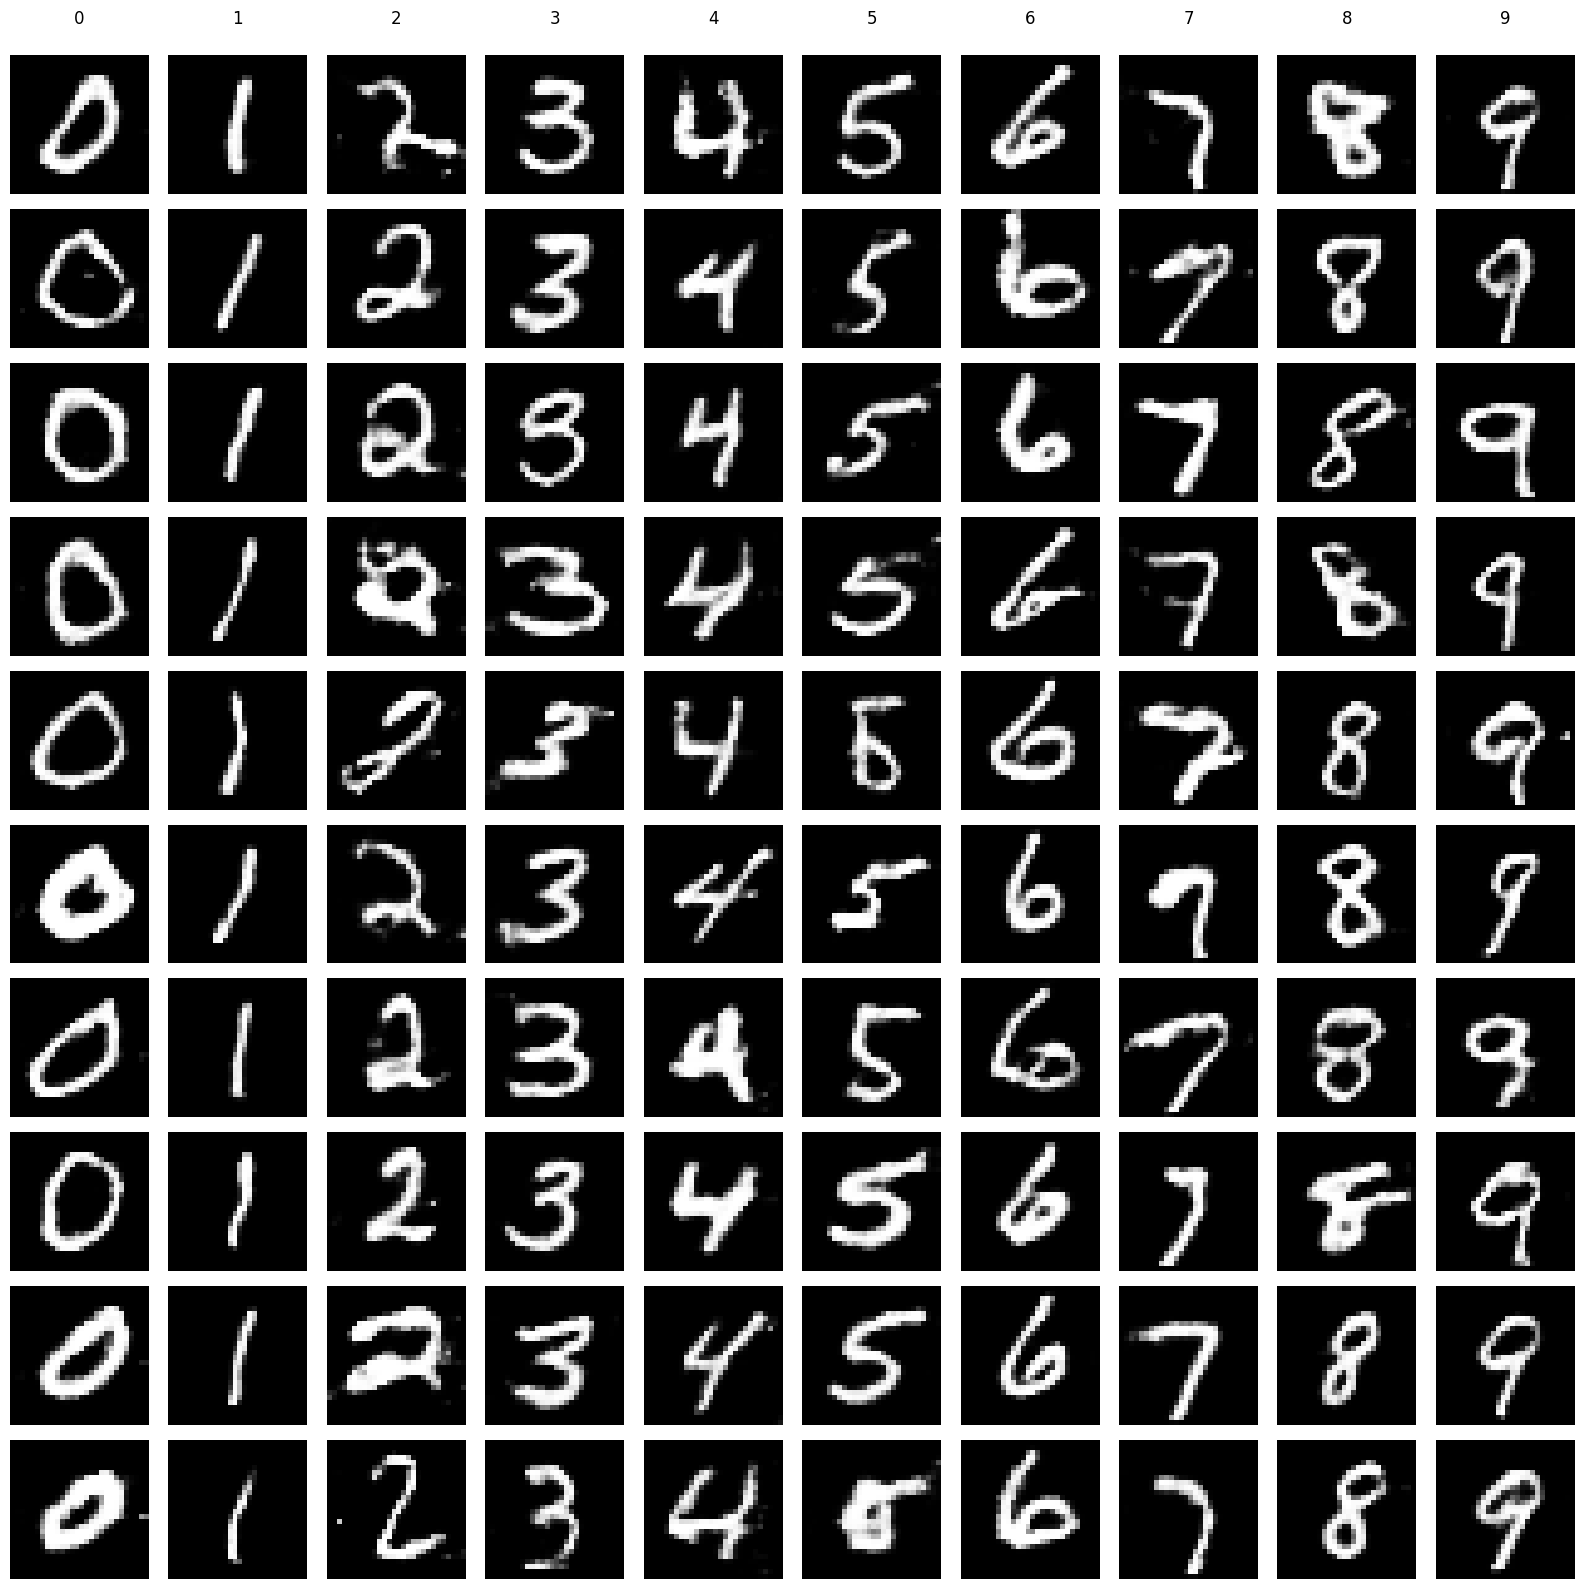

In [88]:
fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
k=0
for i in range(0,10):
    for j in range(0,10):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[0,j].set(title=labels[k])
        axs[i,j].axis('off')
        k=k+1
plt.show() 
